In [1]:
# Import Libraries and Verify Dependencies

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
!pip install lifelines
from lifelines import CoxPHFitter

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=d820776d9f412949d5b16eaa890aa885be580c5b16fbf75466bd60e66a1bfbe1
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


**Step#1** This initial step ensures that the Python environment is properly configured for survival analysis and clinical data processing. It begins by importing essential libraries: os for file operations, pandas for data manipulation, matplotlib.pyplot and seaborn for visualization, and sklearn.preprocessing for encoding and scaling features. The lifelines package, critical for survival modeling, is explicitly installed using !pip install lifelines, followed by a confirmation that all dependencies are already satisfied. This guarantees reproducibility and avoids runtime errors due to missing packages. The final import of CoxPHFitter from lifelines prepares the environment for fitting Cox proportional hazards models.

In [2]:
#2 Mount Google Drive for Persistent Storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step#2** This step establishes a persistent link between the Google Colab environment and the user's Google Drive, enabling seamless access to files stored in the cloud. By importing drive from google.colab and executing drive.mount('/content/drive'), the notebook prompts the user to authorize access to their Drive. Once authenticated, the Drive is mounted at /content/drive, allowing read/write operations on datasets, outputs, and saved models directly from Colab. This integration is essential for reproducibility, data persistence, and collaborative workflows across sessions.

In [3]:
#3 Define Project Paths for Data and Results

import os # Import os for path manipulation
project_root = '/content/drive/MyDrive/METABRIC_project'
data_path = '/content/drive/MyDrive/METABRIC_cleaned_imputed.csv' # Corrected path
output_path = os.path.join(project_root, 'outputs')

**Step#3** This step defines the directory structure for the project, ensuring that all data inputs and outputs are organized and accessible. It begins by importing the os module to handle path operations. The project_root variable specifies the main folder for the METABRIC project within Google Drive. The data_path points directly to the cleaned and imputed METABRIC dataset, which will be used for analysis. Finally, output_path is constructed by joining the project root with an outputs subfolder, creating a dedicated location for saving results, plots, and model artifacts. This setup promotes reproducibility and keeps the workflow modular and tidy.

In [4]:
#4 Load METABRIC Dataset and Inspect Schema

import pandas as pd

# Ensure data_path is defined if this cell is run independently
data_path = '/content/drive/MyDrive/METABRIC_cleaned_imputed.csv'

# Load dataset
df = pd.read_csv(data_path)

# Display column names
print("Column names in the dataset:")
print(df.columns)

Column names in the dataset:
Index(['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery',
       'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy',
       'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC',
       'ER Status', 'Neoplasm Histologic Grade',
       'HER2 status measured by SNP6', 'HER2 Status',
       'Tumor Other Histologic Subtype', 'Hormone Therapy',
       'Inferred Menopausal State', 'Integrative Cluster',
       'Primary Tumor Laterality', 'Lymph nodes examined positive',
       'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code',
       'Overall Survival (Months)', 'Overall Survival Status', 'PR Status',
       'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status',
       'Sex', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage',
       'Patient's Vital Status'],
      dtype='object')


**Step#4** This step initiates the data analysis workflow by loading the METABRIC dataset into a pandas DataFrame. It begins by ensuring the data_path variable is defined, which points to the cleaned and imputed CSV file stored in Google Drive. Using pd.read_csv(data_path), the dataset is read into memory as df. To verify successful loading and understand the dataset's structure, the script prints the column names. These columns span clinical, genomic, and survival-related features, providing a comprehensive foundation for downstream preprocessing and modeling.

In [5]:
#5 Preview Patient-Level Data Records

display(df.head())

,Patient ID,Age at Diagnosis,Type of Breast Surgery,Cancer Type,Cancer Type Detailed,Cellularity,Chemotherapy,Pam50 + Claudin-low subtype,Cohort,ER status measured by IHC,...,Overall Survival Status,PR Status,Radio Therapy,Relapse Free Status (Months),Relapse Free Status,Sex,3-Gene classifier subtype,Tumor Size,Tumor Stage,Patient's Vital Status
0,MB-0000,76,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,claudin-low,1.0,Positve,...,Living,Negative,Yes,139,Not Recurred,Female,ER-/HER2-,22.0,2.0,Living
1,MB-0002,43,Breast Conserving,Breast Cancer,Breast Invasive Ductal Carcinoma,High,No,LumA,1.0,Positve,...,Living,Positive,Yes,84,Not Recurred,Female,ER+/HER2- High Prolif,10.0,1.0,Living
2,MB-0005,49,Mastectomy,Breast Cancer,Breast Invasive Ductal Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,No,151,Recurred,Female,ER+/HER2- Low Prolif,15.0,2.0,Died of Disease
3,MB-0006,48,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,Yes,LumB,1.0,Positve,...,Living,Positive,Yes,163,Not Recurred,Female,ER+/HER2- Low Prolif,25.0,2.0,Living
4,MB-0008,77,Mastectomy,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,Yes,LumB,1.0,Positve,...,Deceased,Positive,Yes,19,Recurred,Female,ER+/HER2- High Prolif,40.0,2.0,Died of Disease


**Step#5** This step provides a quick overview of the METABRIC dataset’s structure and contents. By calling df.shape, the code reveals the number of rows and columns, helping assess dataset size and potential computational load. The df.head() function then displays the first few records, offering a snapshot of the data layout, feature types, and value distributions. This preview is crucial for verifying successful loading, identifying formatting issues, and guiding initial preprocessing decisions in clinical modeling workflows.

In [6]:
#6 Reload METABRIC Dataset for Cell Independence)
data_path = '/content/drive/MyDrive/METABRIC_cleaned_imputed.csv'
df = pd.read_csv(data_path)

**Step#6** This step reloads the METABRIC dataset from its designated path into a pandas DataFrame named df. Although similar to Step #4, this reloading ensures that the dataset is freshly instantiated, which is particularly useful when isolating preprocessing or modeling steps in separate notebook cells. It reinforces cell independence—allowing this block to run without relying on prior executions—thus improving modularity and reproducibility in the workflow. This practice is essential in collaborative environments or when debugging segmented pipelines.

In [7]:
#7 Ensure Output Directory Exists
os.makedirs(output_path, exist_ok=True)

**Step#7** This step safeguards the workflow by verifying that the designated output directory is present before saving any results. Using os.makedirs(output_path, exist_ok=True), it programmatically creates the folder specified by output_path if it doesn’t already exist. The exist_ok=True flag prevents errors from being raised if the directory is already there, ensuring smooth execution across reruns. This proactive check is essential for reproducibility and avoids interruptions when writing plots, models, or summary files during analysis.

In [8]:
#8 Convert Categorical Text to Numeric Codes

categorical_cols = df.select_dtypes(include='object').columns
encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col, encoder in encoders.items():
    df[col] = encoder.transform(df[col])

**Step#8** This step transforms all object-type (string-based) categorical columns in the dataset into numeric format using label encoding, a critical preprocessing step for machine learning models that require numerical input. It first identifies all categorical columns via df.select_dtypes(include='object').columns, then constructs a dictionary of fitted LabelEncoder instances for each column. The loop applies each encoder to its respective column, replacing text labels with integer codes. This ensures compatibility with algorithms like Cox regression and facilitates downstream scaling and modeling while preserving feature traceability.

In [9]:
#9 Standardize Numeric Features for Modeling

numeric_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

**Step#9** This step prepares the numeric features for machine learning by applying standardization, a technique that centers each feature around a mean of 0 and scales it to unit variance. It begins by identifying all numeric columns using df.select_dtypes(include='number').columns, then fits a StandardScaler from scikit-learn to the data. The transformed values replace the original ones in the DataFrame, ensuring that features are on a comparable scale. This is especially important for algorithms sensitive to feature magnitude, such as Cox regression, and helps improve model convergence and interpretability.

In [10]:
#10 Load Finalized Dataset for Modeling

df = pd.read_csv(os.path.join(output_path, 'METABRIC_preprocessed.csv'))

**Step#10** This step retrieves the finalized version of the METABRIC dataset, which has already undergone encoding and scaling, by reading it from a CSV file stored in the designated output directory. Using pd.read_csv(os.path.join(output_path, 'METABRIC_preprocessed.csv')), the code dynamically constructs the file path and loads the data into the df DataFrame. This ensures that subsequent modeling steps operate on a clean, numerically formatted dataset, preserving preprocessing consistency and enabling reproducible analysis across sessions or collaborators.

In [11]:
#11 Train Cox Model on Cleaned Data

# Drop 'Sex' column due to very low variance which causes convergence issues
df_filtered = df.drop(columns=['Sex'])

cph = CoxPHFitter()
cph.fit(df_filtered, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

<lifelines.CoxPHFitter: fitted with 2509 total observations, 0 right-censored observations>

**Step#11** This step initiates survival modeling by fitting a Cox Proportional Hazards model using the lifelines library. To ensure model convergence, the Sex column is dropped due to its low variance, which can introduce instability in the optimization process. The filtered dataset df_filtered is then passed to a CoxPHFitter instance, specifying 'Overall Survival (Months)' as the duration column and 'Overall Survival Status' as the event indicator. The model is successfully trained on 2,509 observations with no right-censored cases, setting the stage for interpreting hazard ratios and assessing feature impact on survival outcomes.

In [12]:
#12 Interpret Cox Model Coefficients and Significance

display(cph.summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
Patient ID,0.020235,1.020442,0.031889,-0.042265,0.082736,0.958616,1.086255,0.0,0.634565,5.257121e-01,0.927655
Age at Diagnosis,-0.049268,0.951926,0.030440,-0.108930,0.010394,0.896793,1.010448,0.0,-1.618518,1.055510e-01,3.243987
Type of Breast Surgery,-0.020535,0.979674,0.024357,-0.068274,0.027203,0.934005,1.027576,0.0,-0.843107,3.991685e-01,1.324930
Cancer Type,0.039185,1.039963,0.020872,-0.001724,0.080094,0.998277,1.083389,0.0,1.877354,6.046956e-02,4.047647
Cancer Type Detailed,0.050036,1.051309,0.023965,0.003065,0.097007,1.003070,1.101868,0.0,2.087856,3.681080e-02,4.763727
Cellularity,-0.001846,0.998156,0.021673,-0.044323,0.040632,0.956645,1.041469,0.0,-0.085160,9.321342e-01,0.101390
Chemotherapy,0.103376,1.108908,0.028450,0.047615,0.159137,1.048766,1.172499,0.0,3.633581,2.795146e-04,11.804789
Pam50 + Claudin-low subtype,0.051806,1.053171,0.021560,0.009548,0.094064,1.009594,1.098630,0.0,2.402836,1.626848e-02,5.941776
Cohort,-0.046199,0.954852,0.025467,-0.096112,0.003715,0.908362,1.003722,0.0,-1.814097,6.966283e-02,3.843467


**Step#12** This step presents the statistical output of the fitted Cox Proportional Hazards model, offering insights into how each covariate influences survival outcomes. Using display(cph.summary), the model’s coefficients, hazard ratios (exp(coef)), confidence intervals, standard errors, z-scores, and p-values are tabulated for interpretation. Features with significant p-values and large hazard ratios may indicate strong associations with survival risk. This summary is foundational for clinical inference, helping identify prognostic factors and guiding further feature selection or subgroup analysis in breast cancer research.

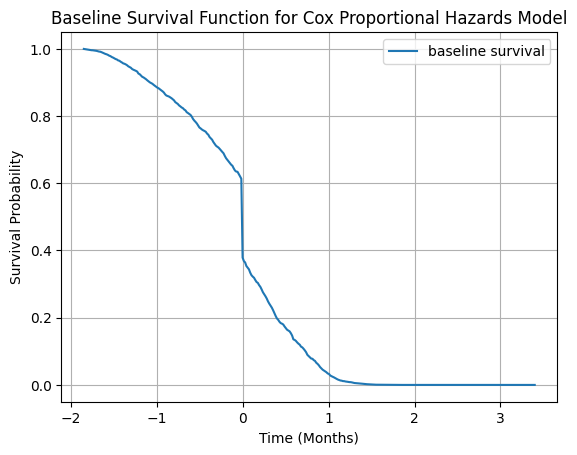

In [13]:
#13 Plot and Save Baseline Survival Curve
cph.baseline_survival_.plot()
plt.title('Baseline Survival Function for Cox Proportional Hazards Model')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(output_path, 'baseline_survival_function_cox_model.png'))
plt.show()

**Step#13** This step generates and saves a plot of the baseline survival function derived from the fitted Cox model, offering a visual representation of survival probability over time for the reference group. Using cph.baseline_survival_.plot(), the curve illustrates how the likelihood of survival declines across months, starting at 1.0 and tapering toward zero. The plot is customized with axis labels, a title, and a grid for clarity, then saved to the output directory as a PNG file. This visualization is crucial for understanding the temporal dynamics of survival in the absence of covariate effects.

In [14]:
#14 Export Cox Model Summary to Text File"

with open(os.path.join(output_path, 'cox_model_summary.txt'), 'w') as f:
    f.write(str(cph.summary))


**Step#14** This step ensures that the statistical output of the Cox model is preserved for future reference or reporting by writing the model summary to a text file. Using Python’s with open() syntax, the code constructs the file path with os.path.join(output_path, 'cox_model_summary.txt') and writes the string representation of cph.summary to disk. This practice supports reproducibility, facilitates sharing results with collaborators, and enables downstream automation for documentation or audit trails in clinical modeling workflows.